In [16]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
from torch.optim import SGD, Adam
import numpy as np, cv2
import matplotlib.pyplot as plt
from glob import glob
from imgaug import augmenters as iaa

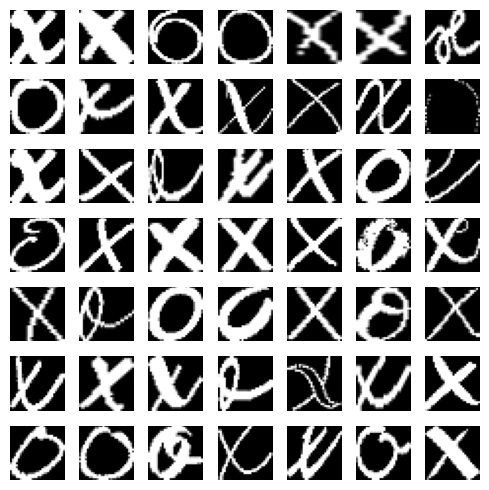

In [22]:
tfm = iaa.Sequential(iaa.Resize(28))
device = "cuda" if torch.cuda.is_available() else "cpu"


class X0(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = self.files[idx]
        im = tfm.augment_image(cv2.imread(f)[:, :, 0])
        im = im[None]
        cl = f.split("/")[-1].split("@")[0] == "x"
        return torch.tensor(1 - im / 255).to(device).float(), torch.tensor(
            [cl]
        ).float().to(device)


data = X0("all/*")
R, C = 7, 7
fig, ax = plt.subplots(R, C, figsize=(5, 5))
for label_class, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False)
        plot_cell.axis("off")
        idx = np.random.choice(1000)
        im, label = data[idx]
        print()
        plot_cell.imshow(im[0].cpu(), cmap="gray")
plt.tight_layout()
plt.show()

In [25]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer


# model, loss_fn, optimizer = get_model()
# summary(model, input_size=(1,28,28))


def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()


def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


def val_loss(x, y, model, loss_fn):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [26]:
trn_dl = DataLoader(X0("all/*"), batch_size=32, drop_last=True)

model, loss_fn, optimizer = get_model()
for epoch in range(5):
    for idx, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

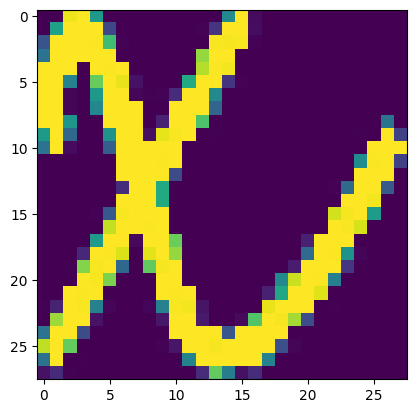

In [29]:
im, c = trn_dl.dataset[2]
plt.imshow(im[0].cpu())
plt.show()

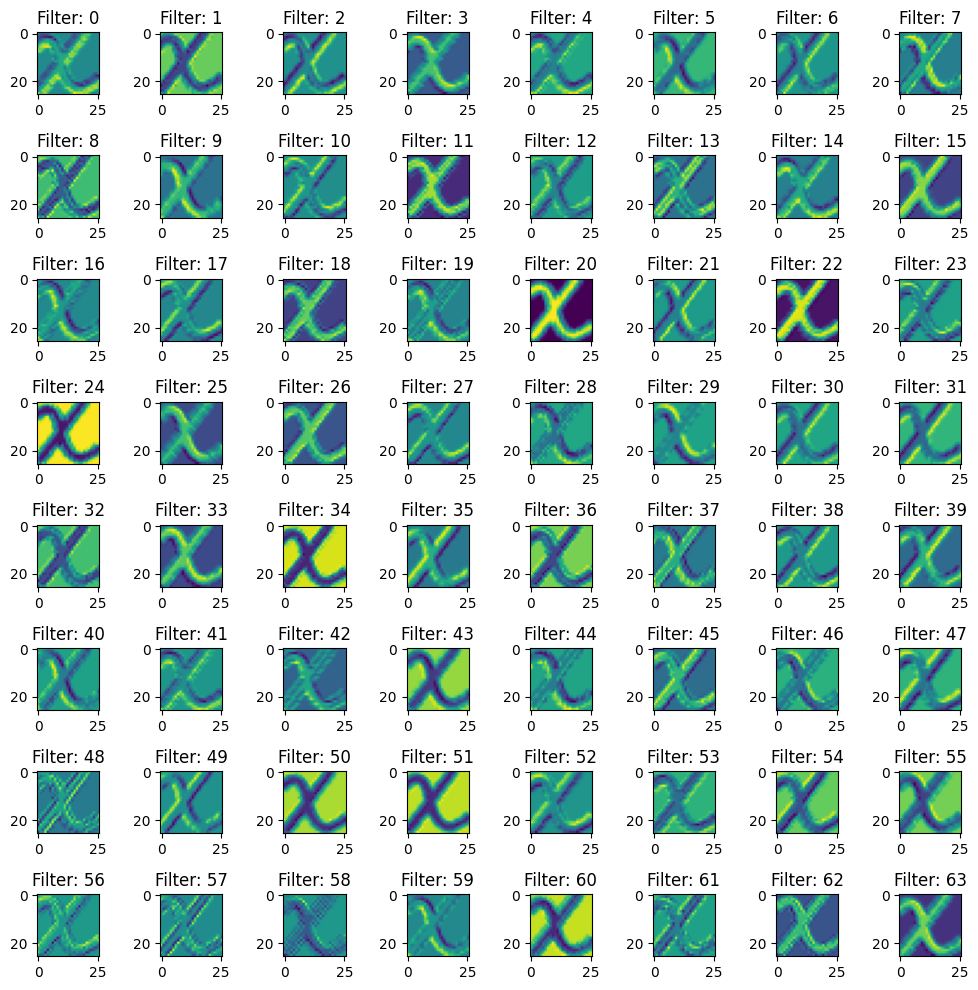

In [28]:
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

n = 8
fig, ax = plt.subplots(n,n,figsize=(10,10))
for idx, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(idx))
    axis.imshow(intermediate_output[idx].cpu())
plt.tight_layout()
plt.show()

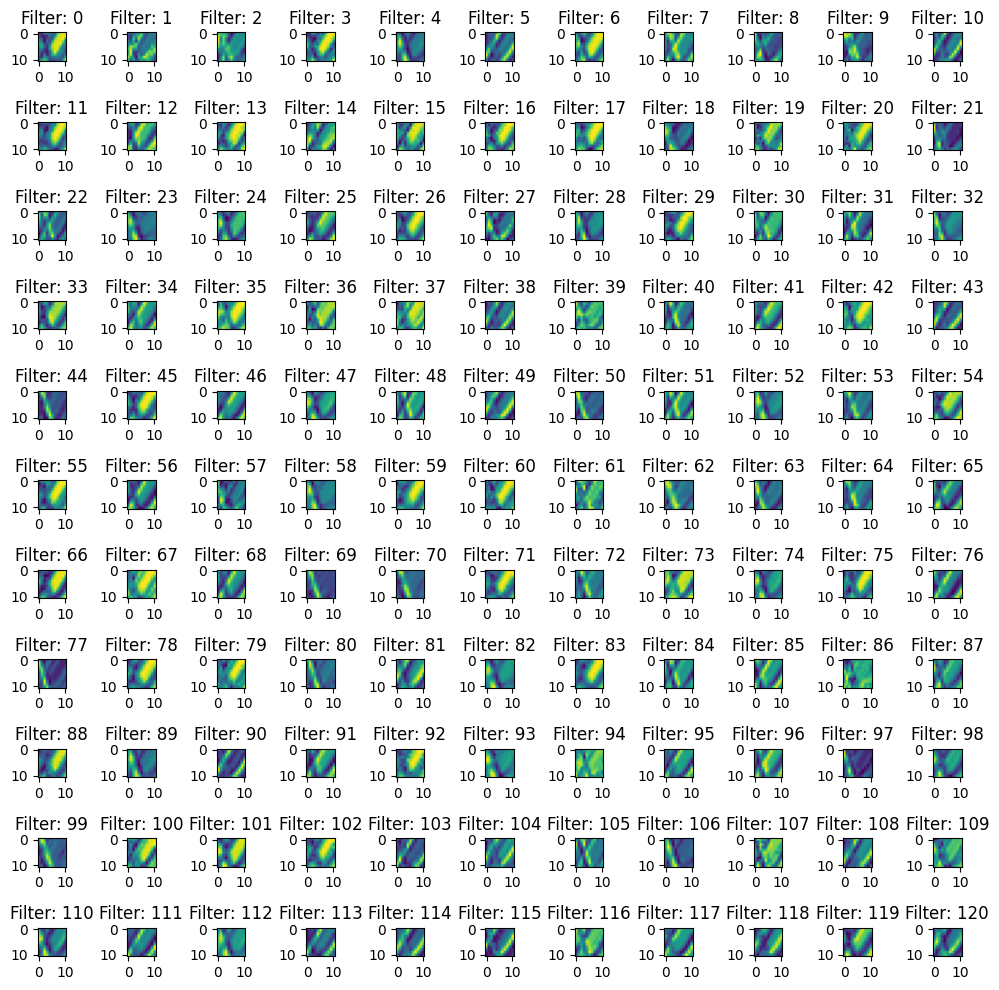

In [30]:
sec_layer = nn.Sequential(*list(model.children())[:4])
sec_intermediate_output = sec_layer(im[None])[0].detach()

n = 11
fig, ax = plt.subplots(n,n,figsize=(10,10))
for idx, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(idx))
    axis.imshow(sec_intermediate_output[idx].cpu())
plt.tight_layout()
plt.show()

IndexError: index 13 is out of bounds for dimension 0 with size 13

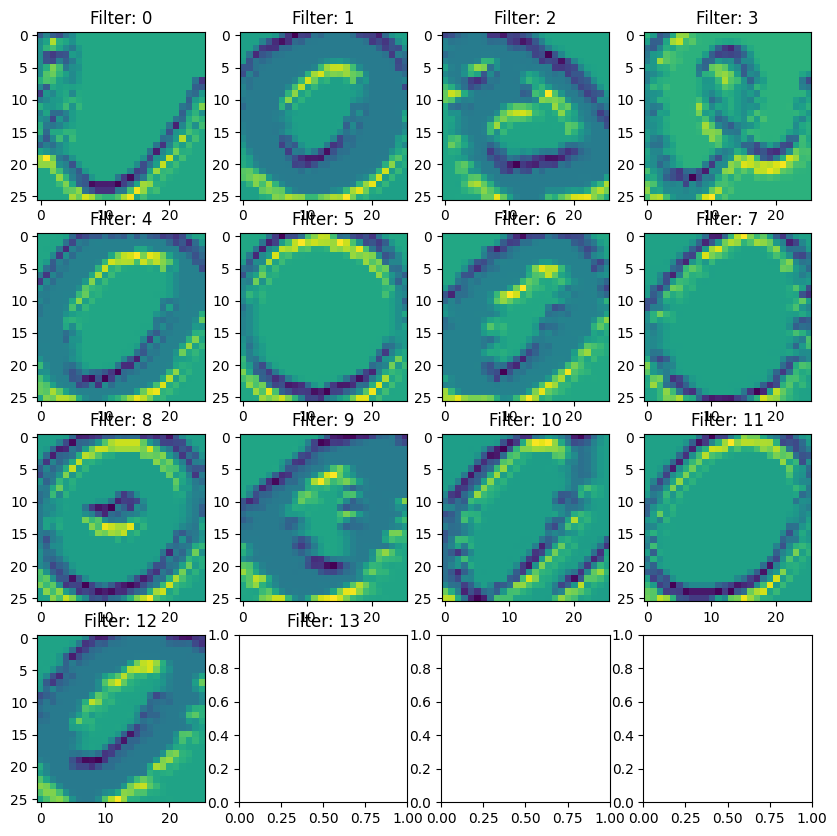

In [31]:
x, y = next(iter(trn_dl))
x2 = x[y == 0]
len(x2)

x2 = x2.view(-1, 1, 28, 28)

first_layer_output = first_layer(x2).detach()

n = 4
fig, ax = plt.subplots(n, n, figsize=(10, 10))
for idx, axis in enumerate(ax.flat):
    axis.set_title("Filter: " + str(idx))
    axis.imshow(first_layer_output[idx, 4, :, :].cpu())
plt.tight_layout()
plt.show()

IndexError: index 13 is out of bounds for dimension 0 with size 13

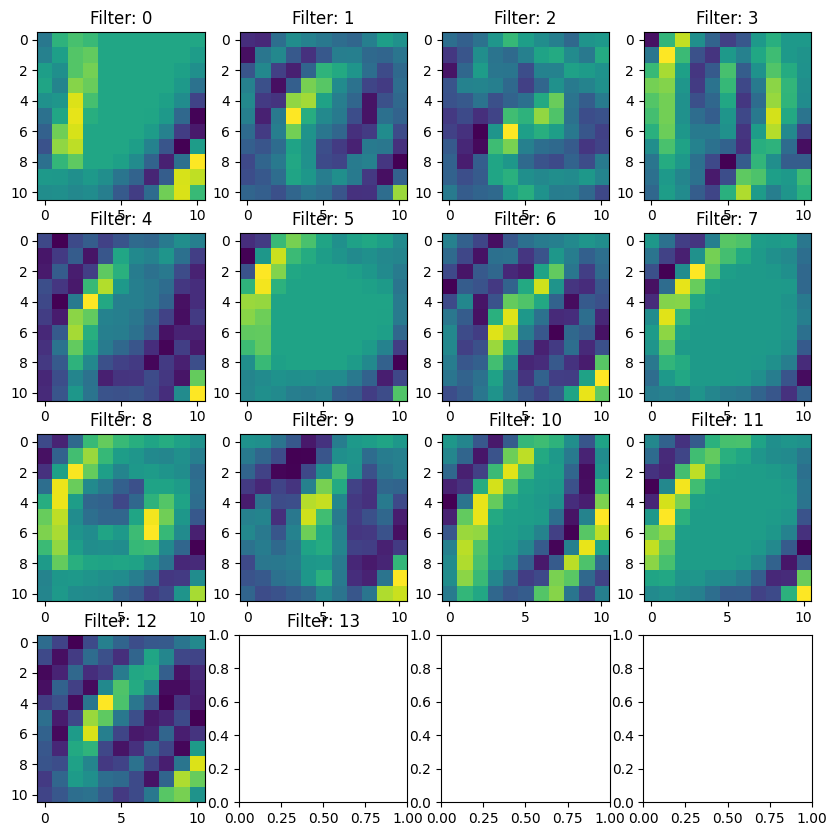

In [32]:
sec_layer_output = sec_layer(x2).detach()

n = 4
fig, ax = plt.subplots(n, n, figsize=(10, 10))
for idx, axis in enumerate(ax.flat):
    axis.set_title("Filter: " + str(idx))
    axis.imshow(sec_layer_output[idx, 34, :, :].cpu())
plt.tight_layout()
plt.show()

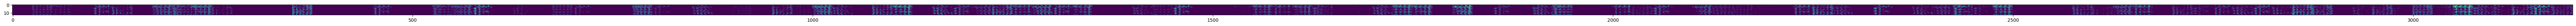

In [34]:
flatten_layer = nn.Sequential(*list(model.children())[:7])
flatten_layer_output = flatten_layer(x2).detach()

plt.figure(figsize=(100,10))
plt.imshow(flatten_layer_output.cpu())